In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import mediapipe as mp

d:\JupyterEnvs\my_new_kernel_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [7]:
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
df = pd.read_csv('CaddieSet_Preprocessed.csv')

print("Dataset shape:", df.shape)
print("\nTarget distribution:")
print(df['Injury_Risk_Level'].value_counts())

Dataset shape: (1757, 94)

Target distribution:
Injury_Risk_Level
Low       1725
Medium      32
Name: count, dtype: int64


In [9]:
df.head()

,View,ClubType,Distance,Carry,LrDistanceOut,DirectionAngle,SpinBack,SpinSide,SpinAxis,BallSpeed,...,Spine_Angle_Range,Shoulder_Rotation_Range,Head_Movement_Range,Head_Movement_Std,Weight_Shift_Impact,Hip_Hanging_Back_Max,Shoulder_Hanging_Back_Max,Left_Arm_Consistency,Injury_Risk_Score,Injury_Risk_Level
0,FACEON,W1,241.0,221.9,0.0,3.9,1705.0,-331.0,-10.986450,63.0,...,12.358,30.326,0.57,0.231812,92.800,0.24,0.42,21.473029,0.157896,Low
1,FACEON,I7,137.7,119.0,0.0,3.0,1868.0,-571.0,-16.997057,45.1,...,11.816,28.206,0.39,0.145419,94.618,0.00,0.05,27.167803,0.183551,Low
2,FACEON,W1,204.7,189.3,0.1,-0.6,2162.0,55.0,1.457256,57.9,...,9.032,27.290,0.25,0.106583,90.770,0.37,0.54,11.599555,0.115764,Low
3,FACEON,I9,125.3,118.5,0.1,3.3,6442.0,-734.0,-6.500235,45.2,...,23.324,40.574,0.80,0.358687,96.780,0.25,0.22,31.248681,0.274319,Low
4,FACEON,W1,214.1,202.9,-32.1,-4.5,2393.0,-462.0,-10.927259,59.0,...,9.378,22.948,1.24,0.462760,95.820,0.12,0.32,20.270000,0.135791,Low


In [10]:
# Separate features and target
X = df.drop(['Injury_Risk_Level'], axis=1)
y = df['Injury_Risk_Level']

In [11]:
# Keep only numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X = X[numeric_cols]

print(f"\nNumber of features: {X.shape[1]}")


Number of features: 91


In [12]:
# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [14]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# One-hot encode target
num_classes = len(np.unique(y_encoded))
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

In [16]:
# Build model
def create_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,),
                    kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model(X_train_scaled.shape[1], num_classes)
print("\nModel architecture:")
model.summary()

d:\JupyterEnvs\my_new_kernel_env\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,178 (86.63 KB)

 Trainable params: 22,178 (86.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, 
                               restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                              patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train_scaled, y_train_categorical,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9733 - loss: 1.8639 - val_accuracy: 0.9751 - val_loss: 1.5964 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 1.3072 - val_accuracy: 0.9751 - val_loss: 1.1255 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.9398 - val_accuracy: 0.9751 - val_loss: 0.8120 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9840 - loss: 0.6798 - val_accuracy: 0.9786 - val_loss: 0.5978 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9858 - loss: 0.5009 - val_accuracy: 0.9786 - val_loss: 0.4681 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9884 - loss: 0.3724 - val_accuracy: 0.9786 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9875 - loss: 0.2898 - val_ac

In [18]:
# Evaluate
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*60}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save model and preprocessors
model.save('injury_risk_model.h5')
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("\nModel, scaler, and label encoder saved!")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 



Test Accuracy: 0.9858 (98.58%)

Classification Report:
              precision    recall  f1-score   support

         Low       0.99      1.00      0.99       346
      Medium       0.67      0.33      0.44         6

    accuracy                           0.99       352
   macro avg       0.83      0.67      0.72       352
weighted avg       0.98      0.99      0.98       352


Model, scaler, and label encoder saved!



GENERATING MODEL VISUALIZATIONS


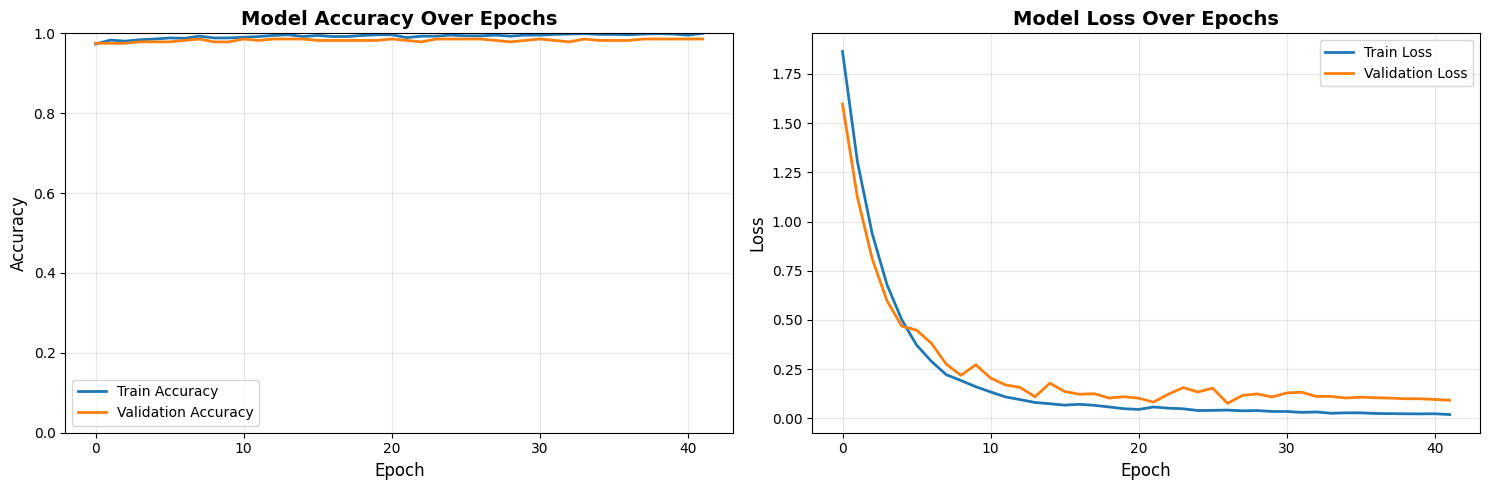

In [25]:
# ============================================================================
# VISUALIZATIONS FOR MODEL PERFORMANCE
# ============================================================================

print("\n" + "="*60)
print("GENERATING MODEL VISUALIZATIONS")
print("="*60)

# 1. Training History Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

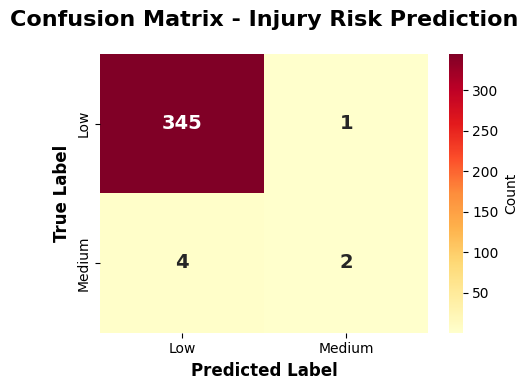

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.title('Confusion Matrix - Injury Risk Prediction', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Part 2

In [38]:
class GolfSwingAnalyzer:
    def __init__(self):
        # MediaPipe 0.10.3+ uses tasks API
        from mediapipe.tasks import python
        from mediapipe.tasks.python import vision
        
        # Download pose landmarker model if not present
        # Model file: pose_landmarker_heavy.task or pose_landmarker_lite.task
        model_path = 'pose_landmarker_lite.task'  # Update this path
        
        base_options = python.BaseOptions(model_asset_path=model_path)
        options = vision.PoseLandmarkerOptions(
            base_options=base_options,
            running_mode=vision.RunningMode.VIDEO,
            num_poses=1,
            min_pose_detection_confidence=0.5,
            min_pose_presence_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.detector = vision.PoseLandmarker.create_from_options(options)
        
        # Landmark indices for MediaPipe Pose
        self.POSE_LANDMARKS = {
            'NOSE': 0,
            'LEFT_EYE_INNER': 1,
            'LEFT_EYE': 2,
            'LEFT_EYE_OUTER': 3,
            'RIGHT_EYE_INNER': 4,
            'RIGHT_EYE': 5,
            'RIGHT_EYE_OUTER': 6,
            'LEFT_EAR': 7,
            'RIGHT_EAR': 8,
            'MOUTH_LEFT': 9,
            'MOUTH_RIGHT': 10,
            'LEFT_SHOULDER': 11,
            'RIGHT_SHOULDER': 12,
            'LEFT_ELBOW': 13,
            'RIGHT_ELBOW': 14,
            'LEFT_WRIST': 15,
            'RIGHT_WRIST': 16,
            'LEFT_PINKY': 17,
            'RIGHT_PINKY': 18,
            'LEFT_INDEX': 19,
            'RIGHT_INDEX': 20,
            'LEFT_THUMB': 21,
            'RIGHT_THUMB': 22,
            'LEFT_HIP': 23,
            'RIGHT_HIP': 24,
            'LEFT_KNEE': 25,
            'RIGHT_KNEE': 26,
            'LEFT_ANKLE': 27,
            'RIGHT_ANKLE': 28,
            'LEFT_HEEL': 29,
            'RIGHT_HEEL': 30,
            'LEFT_FOOT_INDEX': 31,
            'RIGHT_FOOT_INDEX': 32
        }
        
    def calculate_angle(self, a, b, c):
        """Calculate angle between three points"""
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        
        radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
        angle = np.abs(radians*180.0/np.pi)
        
        if angle > 180.0:
            angle = 360-angle
            
        return angle
    
    def extract_features_from_frame(self, landmarks):
        """Extract biomechanical features from pose landmarks"""
        features = {}
        
        # Get landmark coordinates (MediaPipe 0.10.3 format)
        def get_landmark(idx):
            return [landmarks[idx].x, landmarks[idx].y]
        
        left_shoulder = get_landmark(self.POSE_LANDMARKS['LEFT_SHOULDER'])
        right_shoulder = get_landmark(self.POSE_LANDMARKS['RIGHT_SHOULDER'])
        left_hip = get_landmark(self.POSE_LANDMARKS['LEFT_HIP'])
        right_hip = get_landmark(self.POSE_LANDMARKS['RIGHT_HIP'])
        left_elbow = get_landmark(self.POSE_LANDMARKS['LEFT_ELBOW'])
        right_elbow = get_landmark(self.POSE_LANDMARKS['RIGHT_ELBOW'])
        left_wrist = get_landmark(self.POSE_LANDMARKS['LEFT_WRIST'])
        right_wrist = get_landmark(self.POSE_LANDMARKS['RIGHT_WRIST'])
        left_knee = get_landmark(self.POSE_LANDMARKS['LEFT_KNEE'])
        right_knee = get_landmark(self.POSE_LANDMARKS['RIGHT_KNEE'])
        nose = get_landmark(self.POSE_LANDMARKS['NOSE'])
        
        # Calculate angles
        features['left_arm_angle'] = self.calculate_angle(left_shoulder, left_elbow, left_wrist)
        features['right_arm_angle'] = self.calculate_angle(right_shoulder, right_elbow, right_wrist)
        features['spine_angle'] = self.calculate_angle(
            [(left_shoulder[0]+right_shoulder[0])/2, (left_shoulder[1]+right_shoulder[1])/2],
            [(left_hip[0]+right_hip[0])/2, (left_hip[1]+right_hip[1])/2],
            [right_hip[0], right_hip[1]+0.1]
        )
        features['shoulder_rotation'] = abs(left_shoulder[0] - right_shoulder[0])
        features['hip_rotation'] = abs(left_hip[0] - right_hip[0])
        
        # Distance calculations
        features['head_shoulder_distance'] = np.sqrt(
            (nose[0] - (left_shoulder[0]+right_shoulder[0])/2)**2 +
            (nose[1] - (left_shoulder[1]+right_shoulder[1])/2)**2
        )
        
        return features
    
    def process_video(self, video_path, output_path=None):
        """Process video and extract features for each frame"""
        import mediapipe as mp
        
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print("Error: Could not open video")
            return None
        
        frame_features = []
        frame_count = 0
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        
        # Video writer setup if output path provided
        if output_path:
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Create MediaPipe Image
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
            
            # Calculate timestamp in milliseconds
            timestamp_ms = int(frame_count * (1000 / fps))
            
            # Process with MediaPipe
            detection_result = self.detector.detect_for_video(mp_image, timestamp_ms)
            
            if detection_result.pose_landmarks:
                # Extract features from first detected pose
                landmarks = detection_result.pose_landmarks[0]
                features = self.extract_features_from_frame(landmarks)
                frame_features.append(features)
                
                # Draw landmarks on frame if output video requested
                if output_path:
                    # Draw pose landmarks
                    for landmark in landmarks:
                        x = int(landmark.x * width)
                        y = int(landmark.y * height)
                        cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)
                    
                    # Draw connections (simplified)
                    connections = [
                        (self.POSE_LANDMARKS['LEFT_SHOULDER'], self.POSE_LANDMARKS['RIGHT_SHOULDER']),
                        (self.POSE_LANDMARKS['LEFT_SHOULDER'], self.POSE_LANDMARKS['LEFT_ELBOW']),
                        (self.POSE_LANDMARKS['LEFT_ELBOW'], self.POSE_LANDMARKS['LEFT_WRIST']),
                        (self.POSE_LANDMARKS['RIGHT_SHOULDER'], self.POSE_LANDMARKS['RIGHT_ELBOW']),
                        (self.POSE_LANDMARKS['RIGHT_ELBOW'], self.POSE_LANDMARKS['RIGHT_WRIST']),
                        (self.POSE_LANDMARKS['LEFT_SHOULDER'], self.POSE_LANDMARKS['LEFT_HIP']),
                        (self.POSE_LANDMARKS['RIGHT_SHOULDER'], self.POSE_LANDMARKS['RIGHT_HIP']),
                        (self.POSE_LANDMARKS['LEFT_HIP'], self.POSE_LANDMARKS['RIGHT_HIP']),
                        (self.POSE_LANDMARKS['LEFT_HIP'], self.POSE_LANDMARKS['LEFT_KNEE']),
                        (self.POSE_LANDMARKS['LEFT_KNEE'], self.POSE_LANDMARKS['LEFT_ANKLE']),
                        (self.POSE_LANDMARKS['RIGHT_HIP'], self.POSE_LANDMARKS['RIGHT_KNEE']),
                        (self.POSE_LANDMARKS['RIGHT_KNEE'], self.POSE_LANDMARKS['RIGHT_ANKLE'])
                    ]
                    
                    for start_idx, end_idx in connections:
                        start = landmarks[start_idx]
                        end = landmarks[end_idx]
                        start_point = (int(start.x * width), int(start.y * height))
                        end_point = (int(end.x * width), int(end.y * height))
                        cv2.line(frame, start_point, end_point, (255, 0, 0), 2)
            
            if output_path:
                out.write(frame)
            
            frame_count += 1
            if frame_count % 30 == 0:
                print(f"Processed {frame_count} frames...")
        
        cap.release()
        if output_path:
            out.release()
        
        print(f"\nTotal frames processed: {frame_count}")
        print(f"Frames with detected pose: {len(frame_features)}")
        
        # Convert to DataFrame
        if frame_features:
            features_df = pd.DataFrame(frame_features)
            return features_df
        else:
            return None


# Part 3

In [40]:
def analyze_risk_factors(features_df, aggregated_features, feature_names):
    """
    Analyze which biomechanical factors contribute to injury risk
    """
    risk_factors = {
        'high_risk': [],
        'moderate_risk': [],
        'low_risk': []
    }
    
    # Define thresholds based on biomechanical research
    # These are example thresholds - adjust based on your domain knowledge
    thresholds = {
        'spine_angle': {'low': (5, 15), 'moderate': (15, 25), 'high': (25, 100)},
        'shoulder_rotation': {'low': (0, 0.3), 'moderate': (0.3, 0.5), 'high': (0.5, 1.0)},
        'left_arm_angle': {'low': (120, 180), 'moderate': (90, 120), 'high': (0, 90)},
        'right_arm_angle': {'low': (120, 180), 'moderate': (90, 120), 'high': (0, 90)},
        'hip_rotation': {'low': (0, 0.2), 'moderate': (0.2, 0.4), 'high': (0.4, 1.0)},
    }
    
    # Analyze each feature
    for feature_name in features_df.columns:
        mean_val = features_df[feature_name].mean()
        std_val = features_df[feature_name].std()
        max_val = features_df[feature_name].max()
        min_val = features_df[feature_name].min()
        
        # Check if feature is in our threshold definitions
        if feature_name in thresholds:
            threshold = thresholds[feature_name]
            
            # Check high risk
            if threshold['high'][0] <= mean_val <= threshold['high'][1]:
                risk_factors['high_risk'].append({
                    'feature': feature_name,
                    'value': mean_val,
                    'reason': f'Average {feature_name.replace("_", " ")} of {mean_val:.2f} is in high-risk range'
                })
            # Check moderate risk
            elif threshold['moderate'][0] <= mean_val <= threshold['moderate'][1]:
                risk_factors['moderate_risk'].append({
                    'feature': feature_name,
                    'value': mean_val,
                    'reason': f'Average {feature_name.replace("_", " ")} of {mean_val:.2f} is in moderate-risk range'
                })
            # Low risk
            else:
                risk_factors['low_risk'].append({
                    'feature': feature_name,
                    'value': mean_val,
                    'reason': f'Average {feature_name.replace("_", " ")} of {mean_val:.2f} is in safe range'
                })
        
        # Check for high variability (inconsistency)
        if std_val > mean_val * 0.3:  # High coefficient of variation
            risk_factors['moderate_risk'].append({
                'feature': f'{feature_name}_variability',
                'value': std_val,
                'reason': f'High variability in {feature_name.replace("_", " ")} (std: {std_val:.2f}) indicates inconsistent movement'
            })
    
    return risk_factors

def generate_injury_explanation(predicted_class, probabilities, risk_factors, features_df):
    """
    Generate detailed explanation for the injury risk prediction
    """
    explanation = {
        'prediction': predicted_class,
        'confidence': probabilities[predicted_class],
        'summary': '',
        'key_factors': [],
        'recommendations': []
    }
    
    # Generate summary based on prediction
    if predicted_class == 'Low':
        explanation['summary'] = (
            f"Your golf swing shows LOW injury risk with {probabilities['Low']*100:.1f}% confidence. "
            "Your biomechanics are generally within safe ranges, but there are still areas for improvement."
        )
        
        # Focus on what they're doing right
        explanation['key_factors'] = [
            "✓ " + factor['reason'] for factor in risk_factors['low_risk'][:3]
        ]
        
        # Add any moderate concerns
        if risk_factors['moderate_risk']:
            explanation['key_factors'].append("\nAreas to monitor:")
            explanation['key_factors'].extend([
                "⚠ " + factor['reason'] for factor in risk_factors['moderate_risk'][:2]
            ])
        
        explanation['recommendations'] = [
            "Continue maintaining good form and technique",
            "Focus on consistency in your swing mechanics",
            "Regular stretching and warm-up routines are important",
            "Monitor any discomfort and adjust technique accordingly"
        ]
    
    elif predicted_class == 'Medium':
        explanation['summary'] = (
            f"Your golf swing shows MEDIUM injury risk with {probabilities['Medium']*100:.1f}% confidence. "
            "Several biomechanical factors indicate potential stress on your body that could lead to injury over time."
        )
        
        # Show moderate and high risk factors
        explanation['key_factors'] = []
        if risk_factors['high_risk']:
            explanation['key_factors'].append("High-risk factors:")
            explanation['key_factors'].extend([
                "⚠⚠ " + factor['reason'] for factor in risk_factors['high_risk'][:3]
            ])
        
        if risk_factors['moderate_risk']:
            explanation['key_factors'].append("\nModerate-risk factors:")
            explanation['key_factors'].extend([
                "⚠ " + factor['reason'] for factor in risk_factors['moderate_risk'][:3]
            ])
        
        explanation['recommendations'] = [
            "Consider working with a golf instructor to improve swing mechanics",
            "Focus on spine angle and shoulder rotation control",
            "Implement a comprehensive stretching and strengthening program",
            "Gradual increase in practice volume to avoid overuse",
            "Regular assessment of swing mechanics",
            "Consider using video analysis for form corrections"
        ]
    
    else:  # High risk
        explanation['summary'] = (
            f"Your golf swing shows HIGH injury risk with {probabilities['High']*100:.1f}% confidence. "
            "Multiple biomechanical factors suggest significant stress that could lead to acute or chronic injury."
        )
        
        # Emphasize high risk factors
        explanation['key_factors'] = []
        if risk_factors['high_risk']:
            explanation['key_factors'].append("Critical risk factors:")
            explanation['key_factors'].extend([
                "🔴 " + factor['reason'] for factor in risk_factors['high_risk']
            ])
        
        if risk_factors['moderate_risk']:
            explanation['key_factors'].append("\nAdditional concerns:")
            explanation['key_factors'].extend([
                "⚠ " + factor['reason'] for factor in risk_factors['moderate_risk'][:2]
            ])
        
        explanation['recommendations'] = [
            "⚠ IMPORTANT: Consult with a golf professional and sports medicine specialist",
            "Immediate focus on correcting swing mechanics before continuing regular play",
            "Consider biomechanical assessment and movement screening",
            "Implement targeted exercises to address muscle imbalances",
            "Reduce swing speed and practice volume until form improves",
            "Use proper warm-up protocols before every session",
            "Consider physical therapy if experiencing any pain or discomfort"
        ]
    
    # Add statistical insights
    explanation['statistics'] = {
        'total_frames_analyzed': len(features_df),
        'average_spine_angle': features_df['spine_angle'].mean() if 'spine_angle' in features_df else None,
        'spine_angle_std': features_df['spine_angle'].std() if 'spine_angle' in features_df else None,
        'shoulder_rotation_range': (
            features_df['shoulder_rotation'].min(), 
            features_df['shoulder_rotation'].max()
        ) if 'shoulder_rotation' in features_df else None
    }
    
    return explanation

def print_injury_explanation(explanation):
    """
    Print formatted injury risk explanation
    """
    print("\n" + "="*80)
    print("INJURY RISK ANALYSIS REPORT")
    print("="*80)
    
    print(f"\n📊 PREDICTION: {explanation['prediction'].upper()} RISK")
    print(f"🎯 Confidence: {explanation['confidence']*100:.1f}%")
    
    print("\n" + "-"*80)
    print("SUMMARY")
    print("-"*80)
    print(explanation['summary'])
    
    print("\n" + "-"*80)
    print("KEY CONTRIBUTING FACTORS")
    print("-"*80)
    for factor in explanation['key_factors']:
        print(factor)
    
    print("\n" + "-"*80)
    print("RECOMMENDATIONS")
    print("-"*80)
    for i, rec in enumerate(explanation['recommendations'], 1):
        print(f"{i}. {rec}")
    
    if explanation['statistics']['total_frames_analyzed']:
        print("\n" + "-"*80)
        print("TECHNICAL STATISTICS")
        print("-"*80)
        print(f"Frames Analyzed: {explanation['statistics']['total_frames_analyzed']}")
        if explanation['statistics']['average_spine_angle']:
            print(f"Average Spine Angle: {explanation['statistics']['average_spine_angle']:.2f}° "
                  f"(±{explanation['statistics']['spine_angle_std']:.2f}°)")
        if explanation['statistics']['shoulder_rotation_range']:
            sr_min, sr_max = explanation['statistics']['shoulder_rotation_range']
            print(f"Shoulder Rotation Range: {sr_min:.3f} - {sr_max:.3f}")
    
    print("\n" + "="*80)

def predict_injury_risk_from_video(video_path, model, scaler, label_encoder, 
                                   output_video_path=None):
    """
    Complete pipeline: Extract features from video and predict injury risk with explanations
    """
    print("="*60)
    print("Starting video analysis...")
    print("="*60)
    
    # Initialize analyzer
    analyzer = GolfSwingAnalyzer()
    
    # Extract features from video
    print("\n1. Extracting features from video using MediaPipe...")
    features_df = analyzer.process_video(video_path, output_video_path)
    
    if features_df is None or len(features_df) == 0:
        print("Error: No pose detected in video")
        return None
    
    print(f"\nExtracted features shape: {features_df.shape}")
    print("\nFeature columns:")
    print(features_df.columns.tolist())
    
    # Aggregate features across frames
    print("\n2. Aggregating features across frames...")
    aggregated_features = pd.DataFrame({
        col: [
            features_df[col].mean(),
            features_df[col].std(),
            features_df[col].max(),
            features_df[col].min(),
            features_df[col].quantile(0.25),
            features_df[col].quantile(0.75)
        ] for col in features_df.columns
    }).T.values.flatten()
    
    print(f"Aggregated feature vector length: {len(aggregated_features)}")
    
    # Pad or truncate to match training data dimensions
    expected_features = scaler.mean_.shape[0]
    if len(aggregated_features) < expected_features:
        aggregated_features = np.pad(
            aggregated_features, 
            (0, expected_features - len(aggregated_features)), 
            'constant'
        )
    elif len(aggregated_features) > expected_features:
        aggregated_features = aggregated_features[:expected_features]
    
    features_array = aggregated_features.reshape(1, -1)
    
    # Scale features
    print("\n3. Scaling features...")
    features_scaled = scaler.transform(features_array)
    
    # Make prediction
    print("\n4. Making prediction...")
    prediction_probs = model.predict(features_scaled, verbose=0)
    predicted_class_idx = np.argmax(prediction_probs)
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    # Convert probabilities to dictionary
    probabilities = dict(zip(label_encoder.classes_, prediction_probs[0]))
    
    # Analyze risk factors
    print("\n5. Analyzing risk factors...")
    risk_factors = analyze_risk_factors(features_df, aggregated_features, 
                                       scaler.feature_names_in_ if hasattr(scaler, 'feature_names_in_') else None)
    
    # Generate explanation
    explanation = generate_injury_explanation(predicted_class, probabilities, 
                                             risk_factors, features_df)
    
    # Print detailed explanation
    print_injury_explanation(explanation)
    
    # Create visualization of risk factors
    visualize_risk_analysis(features_df, predicted_class, probabilities, risk_factors)
    
    return {
        'predicted_class': predicted_class,
        'probabilities': probabilities,
        'features_df': features_df,
        'aggregated_features': aggregated_features,
        'risk_factors': risk_factors,
        'explanation': explanation
    }

def visualize_risk_analysis(features_df, predicted_class, probabilities, risk_factors):
    """
    Create visualizations for risk analysis
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Prediction probabilities
    ax1 = fig.add_subplot(gs[0, :])
    classes = list(probabilities.keys())
    probs = list(probabilities.values())
    colors = ['#2ecc71' if c == 'Low' else '#f39c12' if c == 'Medium' else '#e74c3c' for c in classes]
    bars = ax1.barh(classes, probs, color=colors, alpha=0.7)
    ax1.set_xlim([0, 1])
    ax1.set_xlabel('Probability', fontsize=12, fontweight='bold')
    ax1.set_title(f'Injury Risk Prediction: {predicted_class.upper()}', 
                  fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        ax1.text(prob + 0.02, i, f'{prob*100:.1f}%', 
                va='center', fontweight='bold', fontsize=11)
    
    # 2. Feature time series
    feature_cols = features_df.columns[:6] if len(features_df.columns) >= 6 else features_df.columns
    for idx, col in enumerate(feature_cols):
        if idx >= 6:
            break
        ax = fig.add_subplot(gs[1 + idx//3, idx%3])
        ax.plot(features_df[col], linewidth=2, color='steelblue')
        ax.fill_between(range(len(features_df)), features_df[col], alpha=0.3)
        ax.set_title(col.replace('_', ' ').title(), fontweight='bold')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_val = features_df[col].mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', 
                  label=f'Mean: {mean_val:.2f}')
        ax.legend(fontsize=8)
    
    plt.savefig('risk_analysis_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Risk factors summary visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    risk_levels = ['high_risk', 'moderate_risk', 'low_risk']
    risk_colors = ['#e74c3c', '#f39c12', '#2ecc71']
    risk_labels = ['High Risk', 'Moderate Risk', 'Low Risk']
    
    for idx, (level, color, label) in enumerate(zip(risk_levels, risk_colors, risk_labels)):
        count = len(risk_factors[level])
        axes[idx].bar([label], [count], color=color, alpha=0.7, width=0.5)
        axes[idx].set_ylabel('Number of Factors', fontweight='bold')
        axes[idx].set_title(f'{label} Factors', fontweight='bold', fontsize=14)
        axes[idx].set_ylim([0, max(len(risk_factors[level]) for level in risk_levels) + 2])
        axes[idx].text(0, count + 0.3, str(count), ha='center', 
                      fontweight='bold', fontsize=16)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('risk_factors_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualizations saved: risk_analysis_visualization.png, risk_factors_summary.png")


<>:12: SyntaxWarning: invalid escape sequence '\S'
<>:12: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Ko Paing Hein\AppData\Local\Temp\ipykernel_4648\3536484632.py:12: SyntaxWarning: invalid escape sequence '\S'
  video_path = 'sample_video\Side-6020-3.mov'  # Replace with your video path



Loading trained model...
Starting video analysis...

1. Extracting features from video using MediaPipe...
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...

Total frames processed: 246
Frames with detected pose: 246

Extracted features shape: (246, 6)

Feature columns:
['left_arm_angle', 'right_arm_angle', 'spine_angle', 'shoulder_rotation', 'hip_rotation', 'head_shoulder_distance']

2. Aggregating features across frames...
Aggregated feature vector length: 36

3. Scaling features...

4. Making prediction...


d:\JupyterEnvs\my_new_kernel_env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



5. Analyzing risk factors...

INJURY RISK ANALYSIS REPORT

📊 PREDICTION: LOW RISK
🎯 Confidence: 100.0%

--------------------------------------------------------------------------------
SUMMARY
--------------------------------------------------------------------------------
Your golf swing shows LOW injury risk with 100.0% confidence. Your biomechanics are generally within safe ranges, but there are still areas for improvement.

--------------------------------------------------------------------------------
KEY CONTRIBUTING FACTORS
--------------------------------------------------------------------------------
✓ Average left arm angle of 155.69 is in safe range
✓ Average right arm angle of 159.19 is in safe range
✓ Average spine angle of 156.67 is in safe range

Areas to monitor:
⚠ High variability in head shoulder distance (std: 0.02) indicates inconsistent movement

--------------------------------------------------------------------------------
RECOMMENDATIONS
--------------------

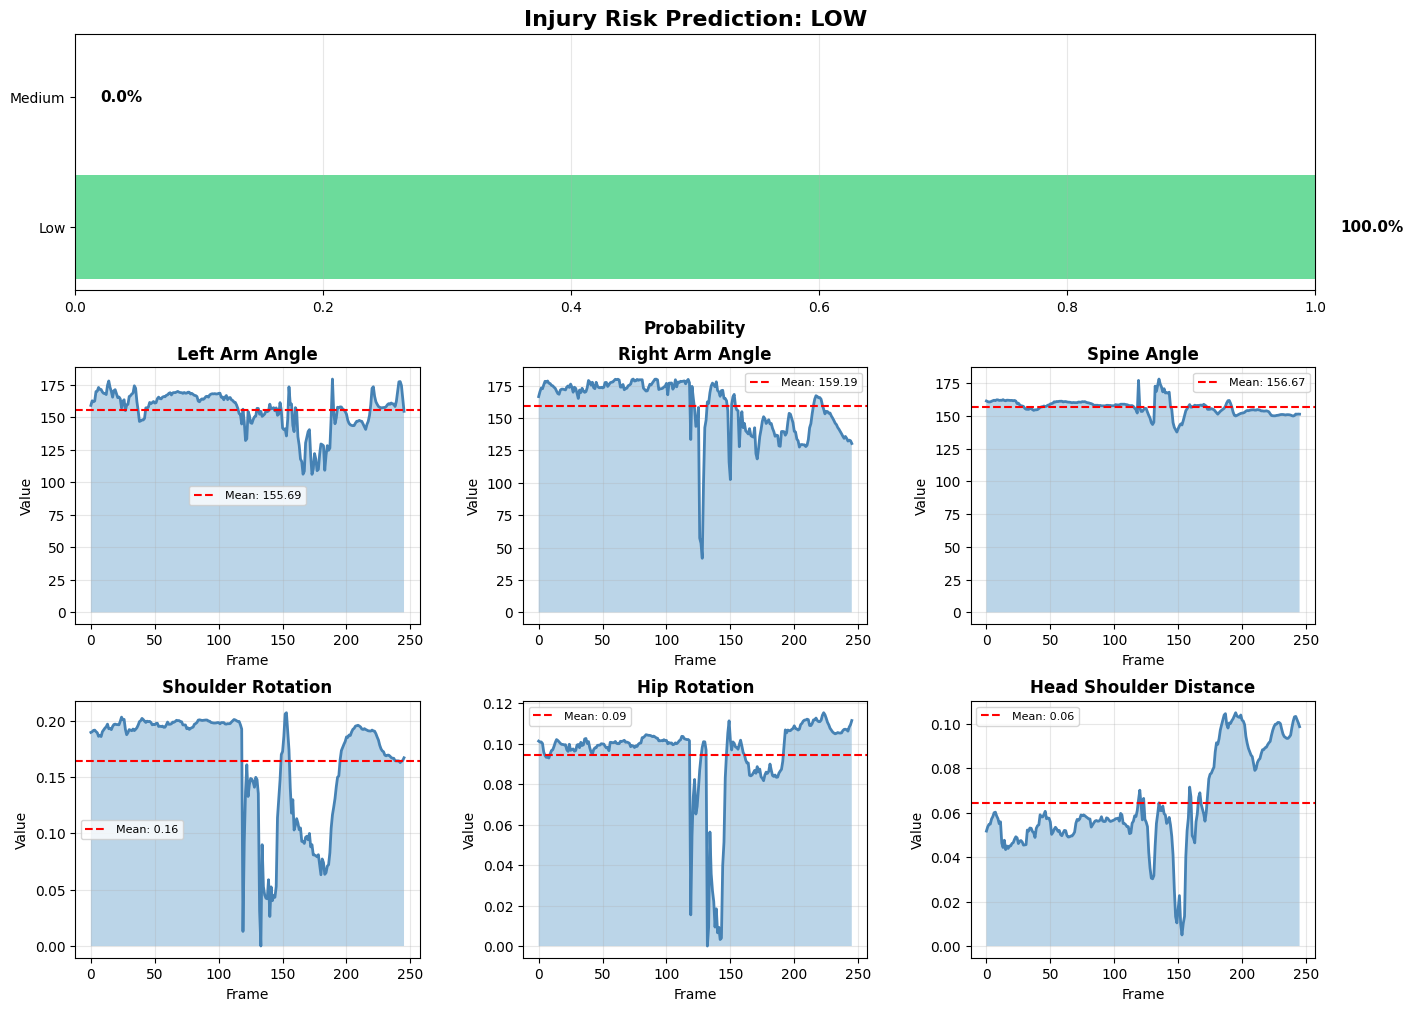

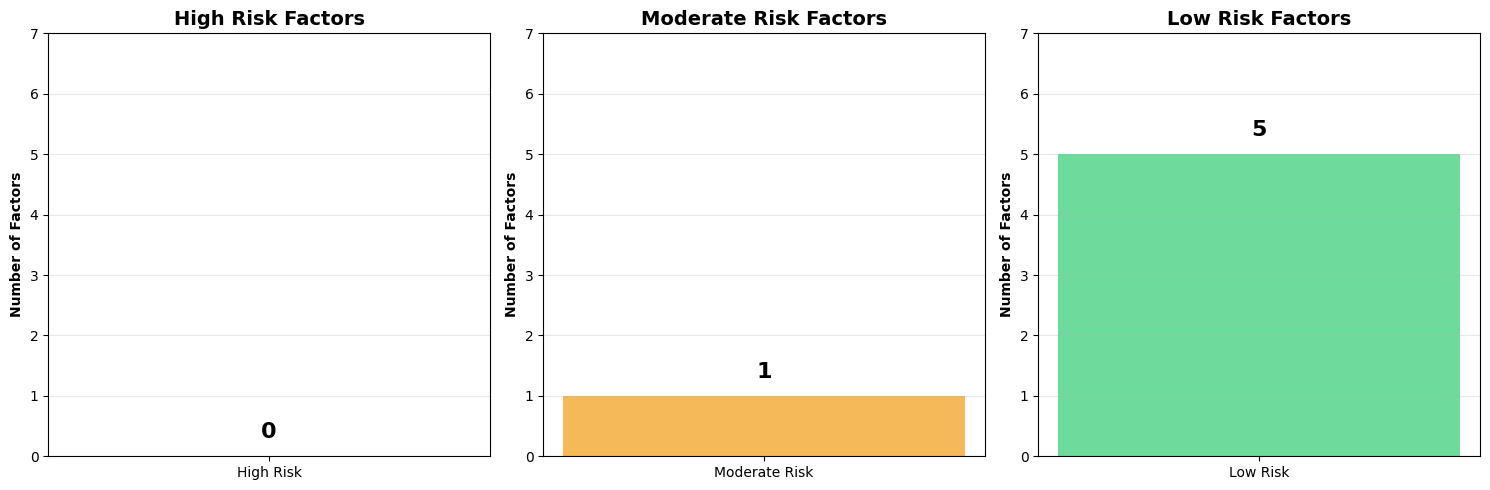


✓ Visualizations saved: risk_analysis_visualization.png, risk_factors_summary.png


Frame-by-frame features preview:
   left_arm_angle  right_arm_angle  spine_angle  shoulder_rotation  \
0      159.027479       166.437975   161.294885           0.189466   
1      162.556740       170.179734   160.808074           0.190054   
2      161.769558       173.053755   160.555338           0.191241   
3      162.420918       172.501573   160.624896           0.191482   
4      169.662798       175.544661   161.090780           0.190174   

   hip_rotation  head_shoulder_distance  
0      0.101228                0.051691  
1      0.100771                0.053596  
2      0.100809                0.054729  
3      0.100054                0.054832  
4      0.095730                0.057121  


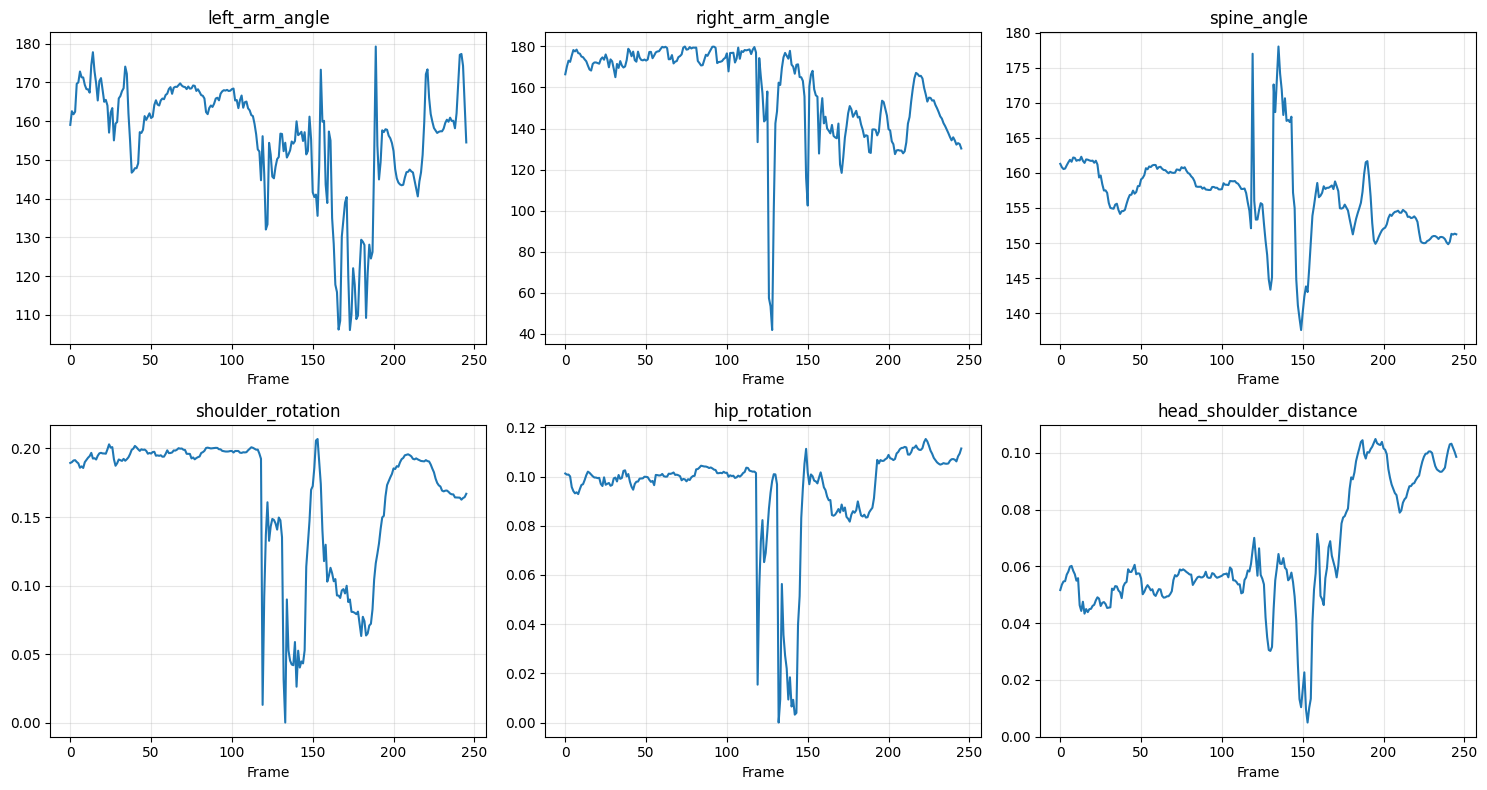

In [42]:
# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Load saved model and preprocessors
print("\nLoading trained model...")
model = keras.models.load_model('injury_risk_model.h5')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Analyze video
video_path = 'sample_video\Side-6020-3.mov'  # Replace with your video path
output_video_path = 'analyzed_video.mp4'  # Optional: save video with pose overlay

results = predict_injury_risk_from_video(
    video_path=video_path,
    model=model,
    scaler=scaler,
    label_encoder=label_encoder,
    output_video_path=output_video_path
)

# Access results
if results:
    print("\n\nFrame-by-frame features preview:")
    print(results['features_df'].head())
    
    # Visualize feature distributions
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(results['features_df'].columns):
        if idx < 6:
            axes[idx].plot(results['features_df'][col])
            axes[idx].set_title(col)
            axes[idx].set_xlabel('Frame')
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()